In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import shap
import plotly.express as px
import webbrowser

In [2]:
# Set visualization style
sns.set(style='whitegrid', palette='muted')


In [3]:
# Load the dataset
df = pd.read_csv('Data-Melbourne_F.csv', na_values={'SLP': [0]})

In [4]:
df.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,TM,Tm,SLP,H,PP,VV,V,VM,VG,year,month,day
0,2.941,2.589,175856,27.0,365.0,730.0,60.378,19.3,25.1,12.6,NaN,56,1.52,10.0,26.9,53.5,79.5,2014,1,1
1,2.936,2.961,181624,25.0,370.0,740.0,60.026,17.1,23.6,12.3,NaN,63,0.00,10.0,14.4,27.8,0.0,2014,1,2
2,2.928,3.225,202016,42.0,418.0,836.0,64.522,16.8,27.2,8.8,NaN,47,0.25,10.0,31.9,61.1,77.8,2014,1,5
3,2.928,3.354,207547,36.0,430.0,850.0,63.000,14.6,19.9,11.1,NaN,49,0.00,10.0,27.0,38.9,53.5,2014,1,6
4,2.917,3.794,202824,46.0,508.0,1016.0,65.590,13.4,19.1,8.0,NaN,65,0.00,10.0,20.6,35.2,53.5,2014,1,7


In [5]:
print(df.head())

   avg_outflow  avg_inflow  total_grid    Am    BOD     COD      TN     T  \
0        2.941       2.589      175856  27.0  365.0   730.0  60.378  19.3   
1        2.936       2.961      181624  25.0  370.0   740.0  60.026  17.1   
2        2.928       3.225      202016  42.0  418.0   836.0  64.522  16.8   
3        2.928       3.354      207547  36.0  430.0   850.0  63.000  14.6   
4        2.917       3.794      202824  46.0  508.0  1016.0  65.590  13.4   

     TM    Tm  SLP   H    PP    VV     V    VM    VG  year  month  day  
0  25.1  12.6  NaN  56  1.52  10.0  26.9  53.5  79.5  2014      1    1  
1  23.6  12.3  NaN  63  0.00  10.0  14.4  27.8   0.0  2014      1    2  
2  27.2   8.8  NaN  47  0.25  10.0  31.9  61.1  77.8  2014      1    5  
3  19.9  11.1  NaN  49  0.00  10.0  27.0  38.9  53.5  2014      1    6  
4  19.1   8.0  NaN  65  0.00  10.0  20.6  35.2  53.5  2014      1    7  


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   avg_outflow  1382 non-null   float64
 1   avg_inflow   1382 non-null   float64
 2   total_grid   1382 non-null   int64  
 3   Am           1382 non-null   float64
 4   BOD          1382 non-null   float64
 5   COD          1382 non-null   float64
 6   TN           1382 non-null   float64
 7   T            1382 non-null   float64
 8   TM           1382 non-null   float64
 9   Tm           1382 non-null   float64
 10  SLP          5 non-null      float64
 11  H            1382 non-null   int64  
 12  PP           1382 non-null   float64
 13  VV           1382 non-null   float64
 14  V            1382 non-null   float64
 15  VM           1382 non-null   float64
 16  VG           1382 non-null   float64
 17  year         1382 non-null   int64  
 18  month        1382 non-null   int64  
 19  day   

In [7]:
# Data Preprocessing

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.drop(['year', 'month', 'day'], axis=1, inplace=True)

df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [8]:
df.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,TM,Tm,SLP,H,PP,VV,V,VM,VG
date,,,,,,,,,,,,,,,,,
2014-01-01,2.941,2.589,175856,27.0,365.0,730.0,60.378,19.3,25.1,12.6,NaN,56,1.52,10.0,26.9,53.5,79.5
2014-01-02,2.936,2.961,181624,25.0,370.0,740.0,60.026,17.1,23.6,12.3,NaN,63,0.00,10.0,14.4,27.8,0.0
2014-01-05,2.928,3.225,202016,42.0,418.0,836.0,64.522,16.8,27.2,8.8,NaN,47,0.25,10.0,31.9,61.1,77.8
2014-01-06,2.928,3.354,207547,36.0,430.0,850.0,63.000,14.6,19.9,11.1,NaN,49,0.00,10.0,27.0,38.9,53.5
2014-01-07,2.917,3.794,202824,46.0,508.0,1016.0,65.590,13.4,19.1,8.0,NaN,65,0.00,10.0,20.6,35.2,53.5


In [9]:
# Handle missing values
# Check missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
avg_outflow       0
avg_inflow        0
total_grid        0
Am                0
BOD               0
COD               0
TN                0
T                 0
TM                0
Tm                0
SLP            1377
H                 0
PP                0
VV                0
V                 0
VM                0
VG                0
dtype: int64


In [10]:
# Remove duplicates if any
df.drop_duplicates(inplace=True)

In [11]:
# Handle missing values
# Check missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
avg_outflow       0
avg_inflow        0
total_grid        0
Am                0
BOD               0
COD               0
TN                0
T                 0
TM                0
Tm                0
SLP            1377
H                 0
PP                0
VV                0
V                 0
VM                0
VG                0
dtype: int64


In [12]:
# Drop rows where key meteorological variables are all zero
df = df[~((df['T'] == 0) & (df['H'] == 0) & (df['V'] == 0))]

# Drop SLP if more than 50% missing
if df['SLP'].isnull().mean() > 0.5:
    df.drop('SLP', axis=1, inplace=True)

In [13]:
# Define targets and features
targets = ['BOD', 'COD', 'TN']
all_columns = df.columns.tolist()
features = [col for col in all_columns if col not in targets]


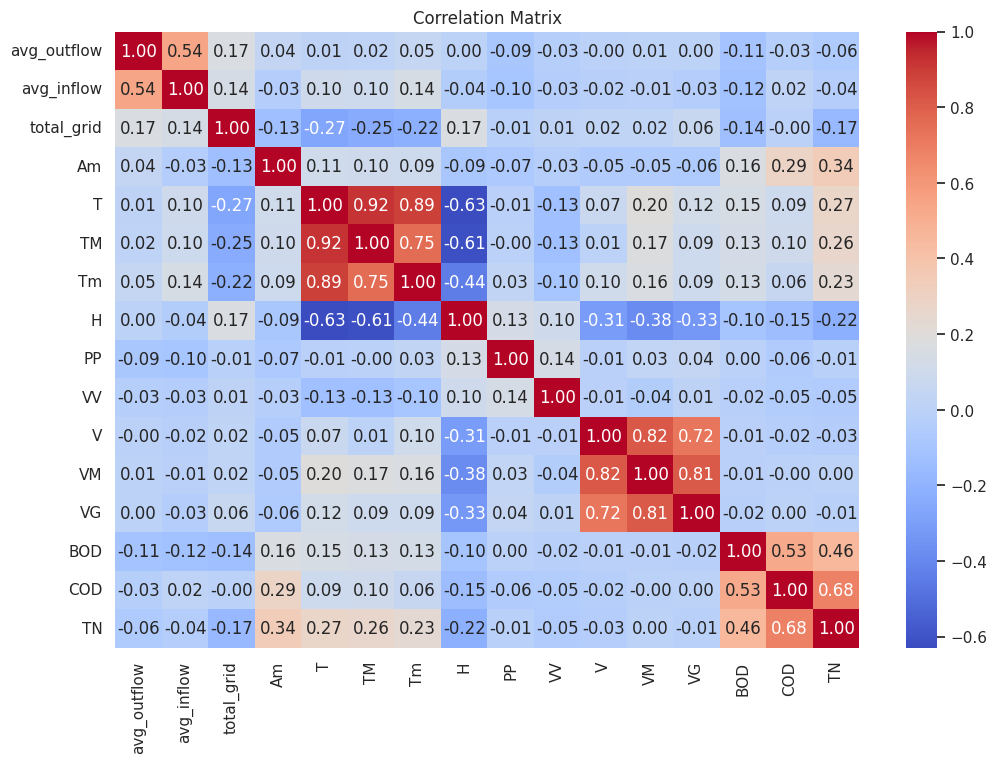

In [14]:
# Exploratory Data Analysis
# Correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[features + targets].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()


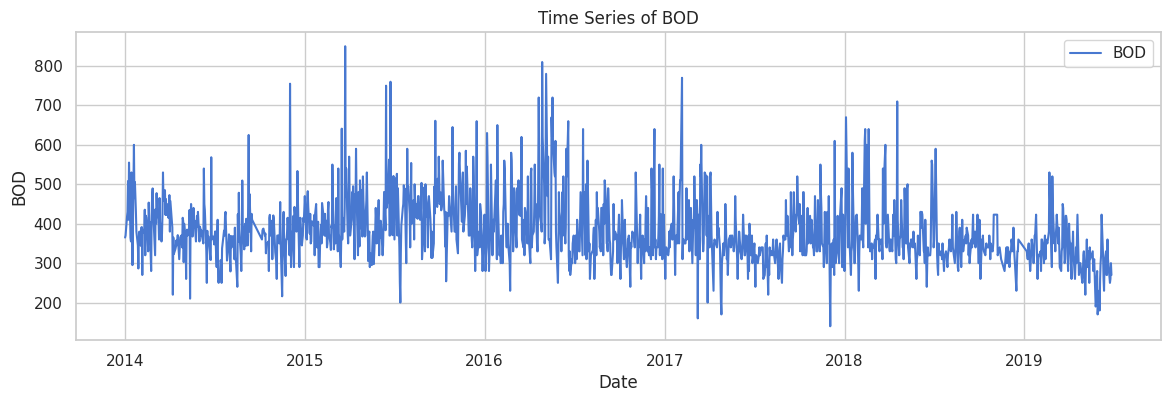

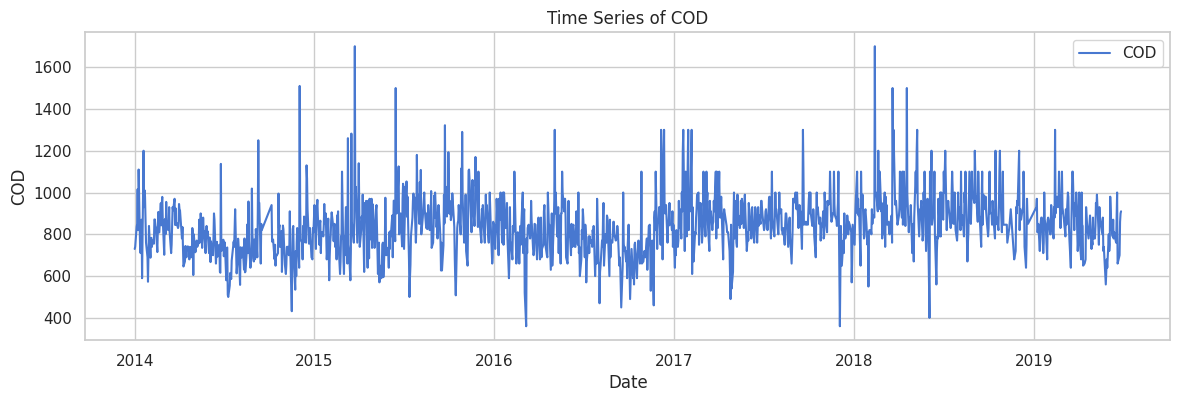

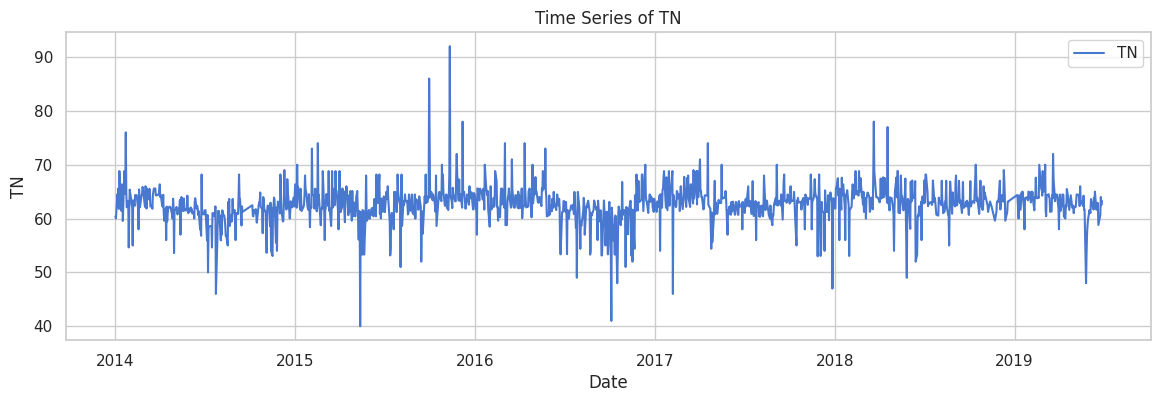

In [15]:
# Time series plots for targets
for target in targets:
    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df[target], label=target)
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.title(f'Time Series of {target}')
    plt.legend()
    plt.savefig(f'time_series_{target}.png')
    plt.show()

In [16]:
# Feature Engineering
# Lag features (3 days)
lag_days = 3
for target in targets:
    for lag in range(1, lag_days + 1):
        df[f'{target}_lag{lag}'] = df[target].shift(lag)

# Rolling means (3-day window)
window_size = 3
for target in targets:
    df[f'{target}_roll_mean'] = df[target].rolling(window=window_size).mean()

# Drop NaNs from lag/rolling
df.dropna(inplace=True)

# Update features
all_columns = df.columns.tolist()
features = [col for col in all_columns if col not in targets]

In [17]:
# Create Sequences for LSTM
time_steps = 30
X_all = []
Y_all = {target: [] for target in targets}
for i in range(len(df) - time_steps):
    X_all.append(df.iloc[i:i + time_steps][features].values)
    for target in targets:
        Y_all[target].append(df.iloc[i + time_steps][target])
X_all = np.array(X_all)
for target in targets:
    Y_all[target] = np.array(Y_all[target])

In [18]:
# Define splits for sequences
total_seq = len(X_all)
train_end = int(0.7 * total_seq)
val_end = int(0.85 * total_seq)
X_train_seq = X_all[:train_end]
X_val_seq = X_all[train_end:val_end]
X_test_seq = X_all[val_end:]

# Split data for tree-based models
train_split = int(0.7 * len(df))
val_split = int(0.85 * len(df))
df_train = df.iloc[:train_split]
df_val = df.iloc[train_split:val_split]
df_test = df.iloc[val_split:]
X_train_tree = df_train[features]
Y_train_tree = df_train[targets]
X_val_tree = df_val[features]
Y_val_tree = df_val[targets]

# Scale features
scaler_X = MinMaxScaler()
scaler_X.fit(X_train_tree)
X_train_tree_scaled = scaler_X.transform(X_train_tree)
X_val_tree_scaled = scaler_X.transform(X_val_tree)
X_all_flat = X_all.reshape(-1, X_all.shape[2])
X_all_scaled = scaler_X.transform(X_all_flat).reshape(X_all.shape)
X_train_seq_scaled = X_all_scaled[:train_end]
X_val_seq_scaled = X_all_scaled[train_end:val_end]
X_test_seq_scaled = X_all_scaled[val_end:]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [19]:
# Scale targets for LSTM
scalers_Y = {}
Y_all_scaled = {}
for target in targets:
    scaler_Y = MinMaxScaler()
    Y_train_target = Y_train_tree[target].values.reshape(-1, 1)
    scaler_Y.fit(Y_train_target)
    scalers_Y[target] = scaler_Y
    Y_all_scaled[target] = scaler_Y.transform(Y_all[target].reshape(-1, 1)).ravel()

In [20]:
# Model Building
# Parameter grids for tree-based models
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
gb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
tscv = TimeSeriesSplit(n_splits=3)

In [21]:
# Initialize storage
best_models = {'RandomForest': {}, 'GradientBoosting': {}, 'XGBoost': {}, 'LSTM': {}}
predictions = {'RandomForest': {}, 'GradientBoosting': {}, 'XGBoost': {}, 'LSTM': {}}
results = []

In [22]:
# Tree-based models
X_train_full_tree = df.iloc[:val_split][features]
Y_train_full_tree = df.iloc[:val_split][targets]
X_train_full_tree_scaled = scaler_X.transform(X_train_full_tree)

for target in targets:
    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    grid_rf = GridSearchCV(rf, rf_params, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_rf.fit(X_train_full_tree_scaled, Y_train_full_tree[target])
    best_models['RandomForest'][target] = grid_rf.best_estimator_

    # Gradient Boosting
    gb = GradientBoostingRegressor(random_state=42)
    grid_gb = GridSearchCV(gb, gb_params, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_gb.fit(X_train_full_tree_scaled, Y_train_full_tree[target])
    best_models['GradientBoosting'][target] = grid_gb.best_estimator_

    # XGBoost
    xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_xgb = GridSearchCV(xgbr, xgb_params, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_xgb.fit(X_train_full_tree_scaled, Y_train_full_tree[target])
    best_models['XGBoost'][target] = grid_xgb.best_estimator_


In [23]:
# LSTM models
for target in targets:
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_all_scaled.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train_seq_scaled, Y_all_scaled[target][:train_end], epochs=100, batch_size=32,
              validation_data=(X_val_seq_scaled, Y_all_scaled[target][train_end:val_end]), callbacks=[es], verbose=0)
    best_models['LSTM'][target] = model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Define common test set
test_start_common = val_end + time_steps
test_end_common = len(df)
X_test_common = df.iloc[test_start_common:test_end_common][features]
X_test_common_scaled = scaler_X.transform(X_test_common)
y_true_common = df.iloc[test_start_common:test_end_common][targets]

# Ensemble Method (Stacking Regressor)
for target in targets:
    # Prepare meta-features (predictions from base models on validation set)
    # Get predictions from tree-based models
    tree_predictions_val = [
        best_models['RandomForest'][target].predict(X_val_tree_scaled),
        best_models['GradientBoosting'][target].predict(X_val_tree_scaled),
        best_models['XGBoost'][target].predict(X_val_tree_scaled)
    ]
    # Get predictions from LSTM and adjust length to match tree-based models
    lstm_pred_val_scaled = best_models['LSTM'][target].predict(X_val_seq_scaled).flatten()
    lstm_pred_val = scalers_Y[target].inverse_transform(lstm_pred_val_scaled.reshape(-1, 1)).flatten()

    # Adjust the length of tree-based model predictions to match LSTM
    num_lstm_preds = len(lstm_pred_val)
    tree_predictions_val_adjusted = [preds[:num_lstm_preds] for preds in tree_predictions_val]

    # Stack predictions
    meta_features_val = np.column_stack(tree_predictions_val_adjusted + [lstm_pred_val])

    # Train meta-model
    meta_model = LinearRegression()
    meta_model.fit(meta_features_val, Y_val_tree[target].values[:len(meta_features_val)])  # Adjust target length
    best_models[f'Ensemble_{target}'] = meta_model

    # Store base model predictions for test set (adjusting for length mismatch)
    # Adjust the length of predictions from tree-based models on test data
    X_test_common_adjusted = X_test_common_scaled[:len(best_models['LSTM'][target].predict(X_test_seq_scaled).flatten())]
    tree_predictions_test_adjusted = [
        best_models['RandomForest'][target].predict(X_test_common_adjusted),
        best_models['GradientBoosting'][target].predict(X_test_common_adjusted),
        best_models['XGBoost'][target].predict(X_test_common_adjusted)
    ]

    meta_features_test = np.column_stack([
        *tree_predictions_test_adjusted, # Unpack the adjusted predictions
        scalers_Y[target].inverse_transform(
            best_models['LSTM'][target].predict(X_test_seq_scaled)).flatten()
    ])
    best_models[f'Ensemble_Meta_{target}'] = meta_features_test

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [26]:
#  Make Predictions
predictions = {}
for target in targets:
    predictions[target] = {}
    # Tree-based models
    predictions[target]['RF'] = best_models['RandomForest'][target].predict(X_test_common_scaled)  # Use X_test_common_scaled and access the correct key
    predictions[target]['GB'] = best_models['GradientBoosting'][target].predict(X_test_common_scaled) # Use X_test_common_scaled and access the correct key
    predictions[target]['XGB'] = best_models['XGBoost'][target].predict(X_test_common_scaled) # Use X_test_common_scaled and access the correct key
    # LSTM
    lstm_pred_scaled = best_models['LSTM'][target].predict(X_test_seq_scaled).flatten()
    # Assuming scalers_Y is the correct dictionary for LSTM targets
    predictions[target]['LSTM'] = scalers_Y[target].inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()
    # Ensemble
    predictions[target]['Ensemble'] = best_models[f'Ensemble_{target}'].predict(
        best_models[f'Ensemble_Meta_{target}'])
    # Actual
    # Assuming y_true_common is the DataFrame containing the actual values
    predictions[target]['actual'] = y_true_common[target].values[:len(predictions[target]['LSTM'])] # Use y_true_common

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [27]:
# Define common test set
test_start_common = val_end + time_steps
test_end_common = len(df)
X_test_common = df.iloc[test_start_common:test_end_common][features]
X_test_common_scaled = scaler_X.transform(X_test_common)
y_true_common = df.iloc[test_start_common:test_end_common][targets]

In [29]:
# Evaluate models
for target in targets:
    for model_type, key in zip(['RandomForest', 'GradientBoosting', 'XGBoost'], ['RF', 'GB', 'XGB']):
        y_pred = best_models[model_type][target].predict(X_test_common_scaled)
        predictions[target][key] = y_pred # Use the correct key here
        mae = mean_absolute_error(y_true_common[target], y_pred)
        rmse = np.sqrt(mean_squared_error(y_true_common[target], y_pred))
        r2 = r2_score(y_true_common[target], y_pred)
        print(f"{model_type} - {target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
        results.append({'Model': model_type, 'Target': target, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

    # LSTM
    y_pred_scaled = best_models['LSTM'][target].predict(X_test_seq_scaled).flatten()
    y_pred = scalers_Y[target].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    predictions[target]['LSTM'] = y_pred
    mae = mean_absolute_error(y_true_common[target], y_pred)
    rmse = np.sqrt(mean_squared_error(y_true_common[target], y_pred))
    r2 = r2_score(y_true_common[target], y_pred)
    print(f"LSTM - {target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    results.append({'Model': 'LSTM', 'Target': target, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

RandomForest - BOD: MAE=18.2605, RMSE=27.4408, R2=0.7433
GradientBoosting - BOD: MAE=12.3761, RMSE=20.4834, R2=0.8569
XGBoost - BOD: MAE=12.8035, RMSE=22.2023, R2=0.8319
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM - BOD: MAE=40.8785, RMSE=51.7586, R2=0.0866
RandomForest - COD: MAE=32.3218, RMSE=43.7321, R2=0.8788
GradientBoosting - COD: MAE=19.2686, RMSE=27.1821, R2=0.9532
XGBoost - COD: MAE=20.4485, RMSE=29.1119, R2=0.9463
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM - COD: MAE=90.8709, RMSE=116.3888, R2=0.1417
RandomForest - TN: MAE=0.6606, RMSE=1.0297, R2=0.8452
GradientBoosting - TN: MAE=0.4440, RMSE=0.6369, R2=0.9408
XGBoost - TN: MAE=0.4431, RMSE=0.6392, R2=0.9403
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM - TN: MAE=1.7762, RMSE=2.5765, R2=0.0306


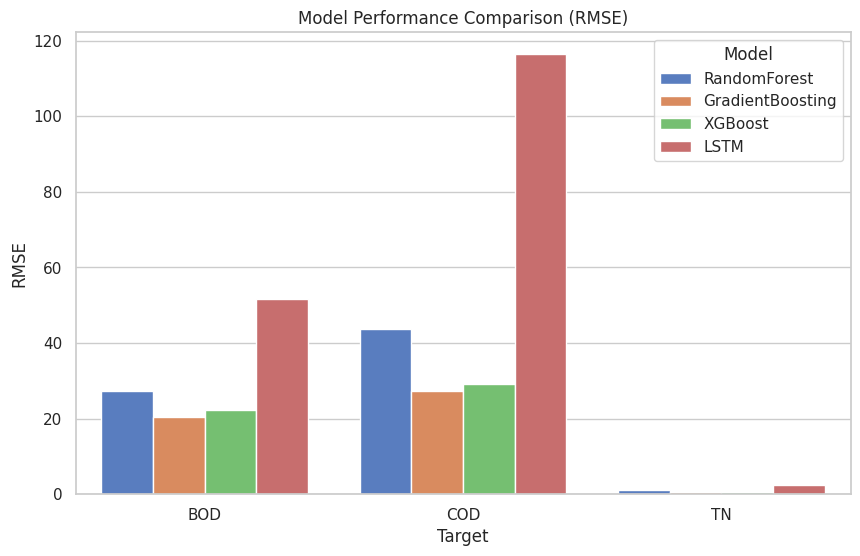

In [30]:
# Visualizations
# Bar chart comparing RMSE
df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Target', y='RMSE', hue='Model', data=df_results)
plt.title('Model Performance Comparison (RMSE)')
plt.savefig('model_performance.png')
plt.show()

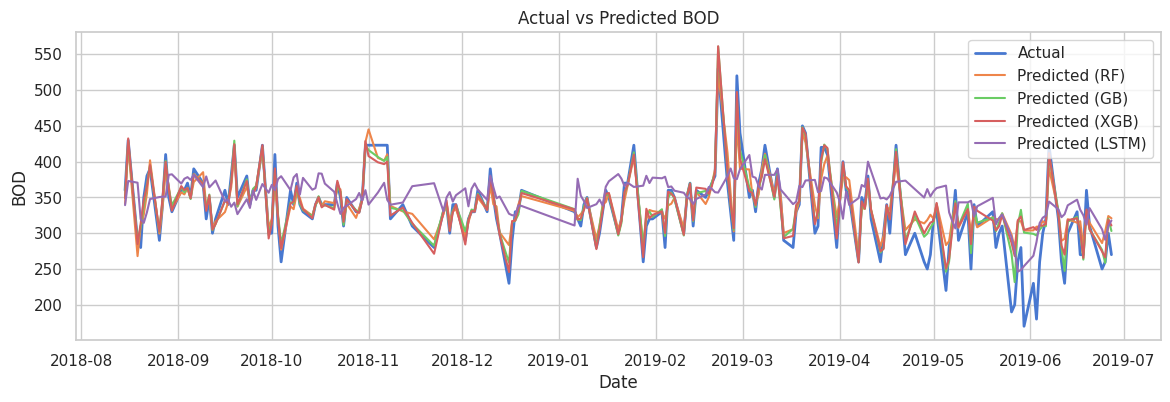

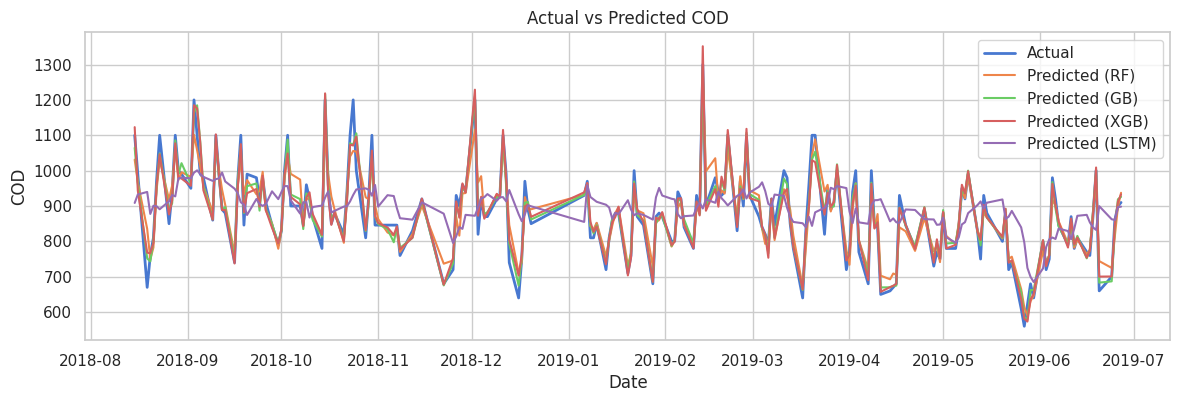

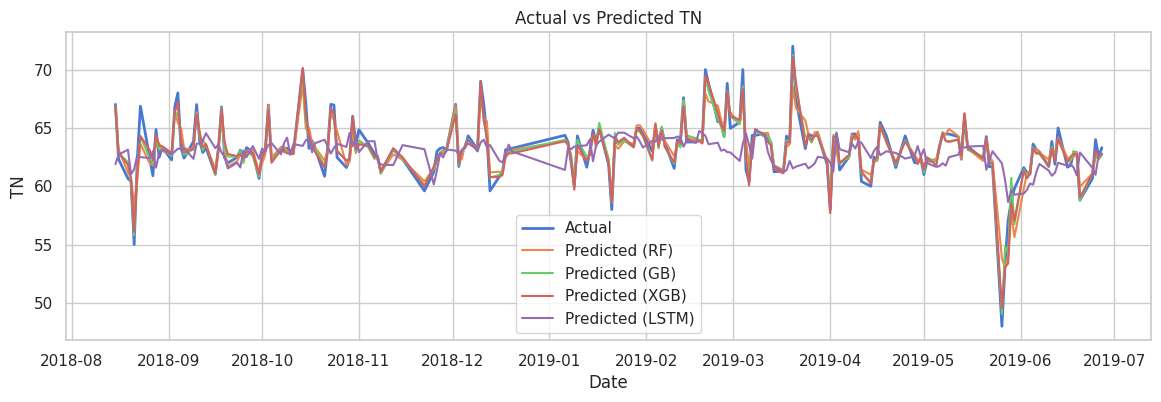

In [33]:
# Time series plots
for target in targets:
    plt.figure(figsize=(14, 4))
    plt.plot(y_true_common.index, y_true_common[target], label='Actual', linewidth=2)
    for model_type in ['RF', 'GB', 'XGB', 'LSTM']:
        plt.plot(y_true_common.index, predictions[target][model_type], label=f'Predicted ({model_type})')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target}')
    plt.legend()
    plt.savefig(f'time_series_pred_{target}.png')
    plt.show()

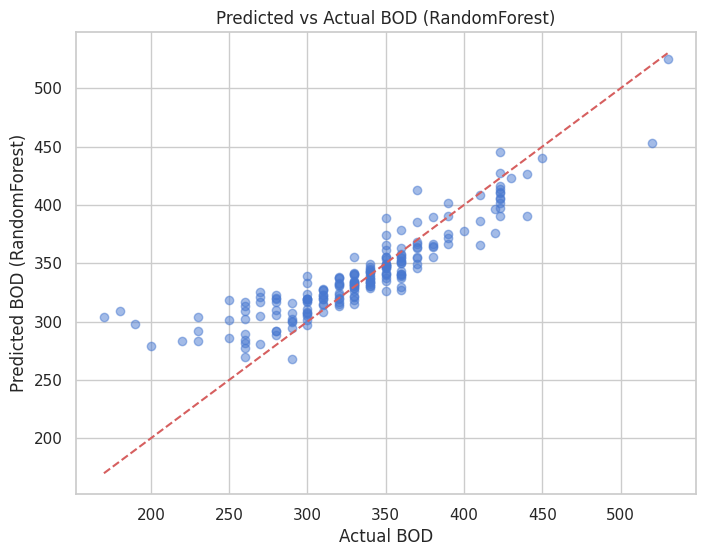

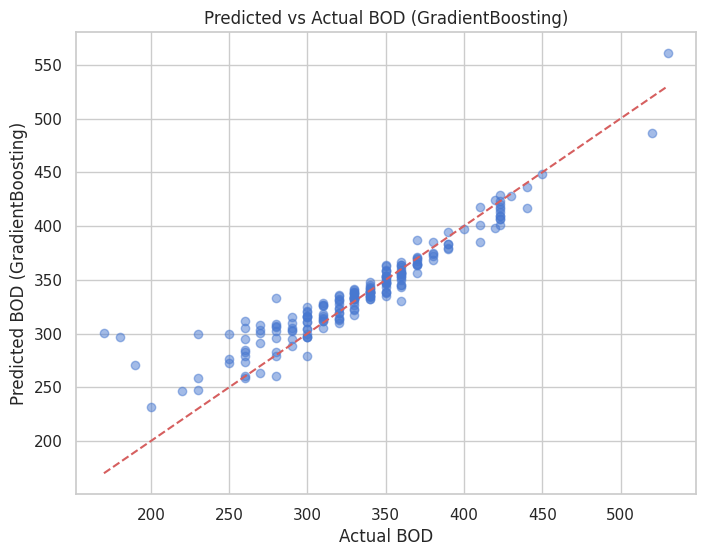

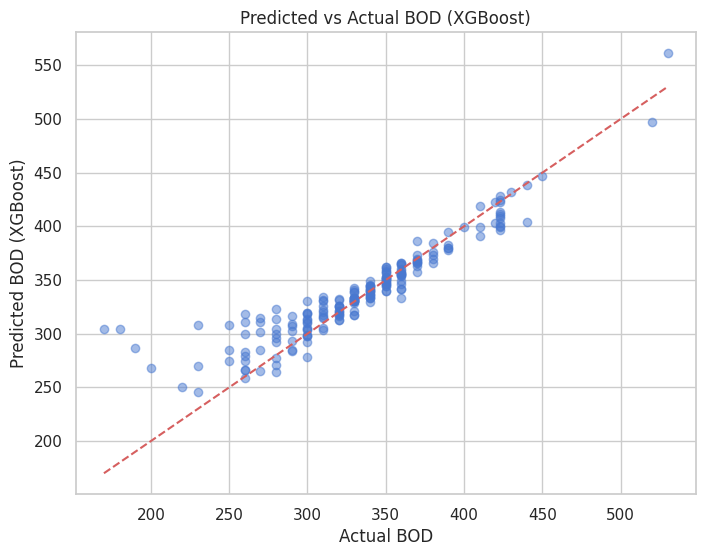

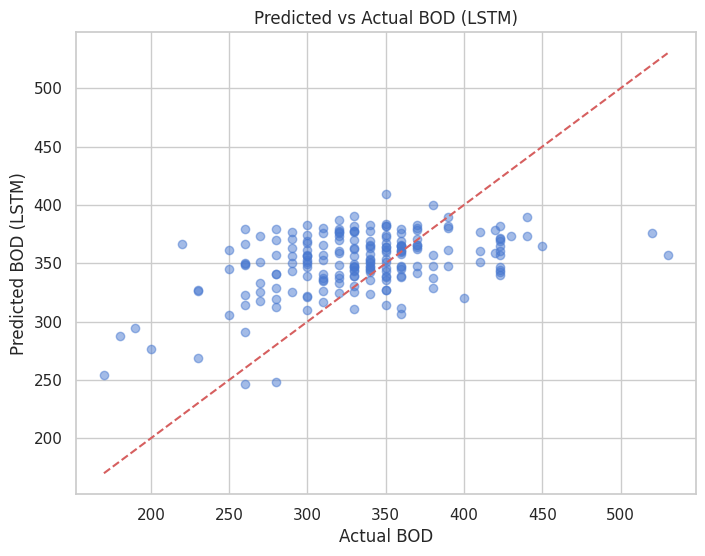

In [35]:
# Scatter plots for BOD
for model_type, key in zip(['RandomForest', 'GradientBoosting', 'XGBoost', 'LSTM'], ['RF', 'GB', 'XGB', 'LSTM']):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true_common['BOD'], predictions['BOD'][key], alpha=0.5)
    plt.plot([y_true_common['BOD'].min(), y_true_common['BOD'].max()],
             [y_true_common['BOD'].min(), y_true_common['BOD'].max()], 'r--')
    plt.xlabel('Actual BOD')
    plt.ylabel(f'Predicted BOD ({model_type})')
    plt.title(f'Predicted vs Actual BOD ({model_type})')
    plt.savefig(f'scatter_bod_{model_type.lower().replace(" ", "_")}.png')
    plt.show()

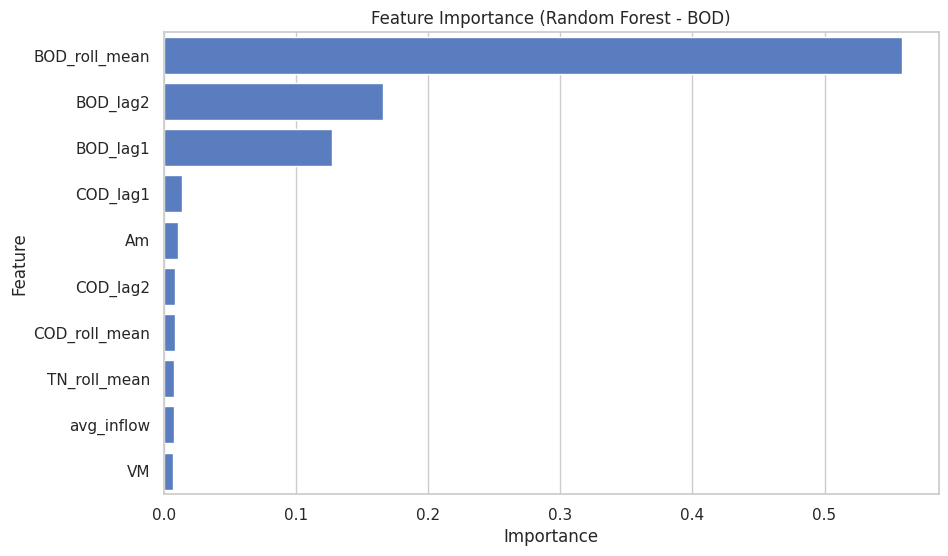

In [38]:
# Feature importance for Random Forest (BOD)
importances = best_models['RandomForest']['BOD'].feature_importances_
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10))
plt.title('Feature Importance (Random Forest - BOD)')
plt.savefig('feature_importance_rf_bod.png')
plt.show()

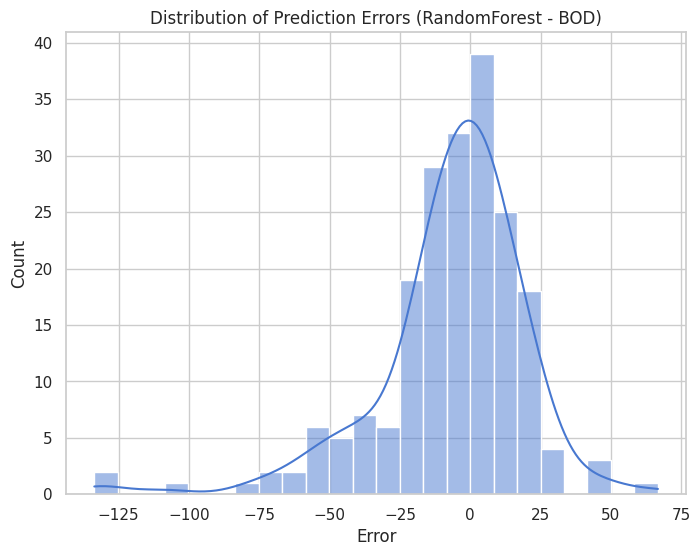

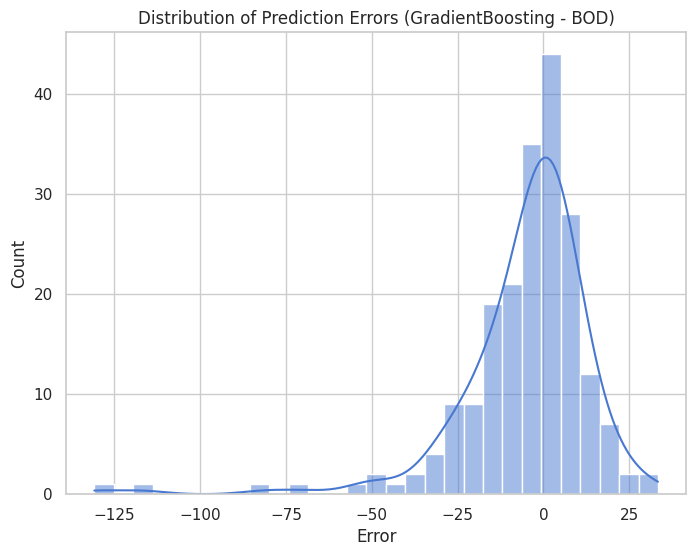

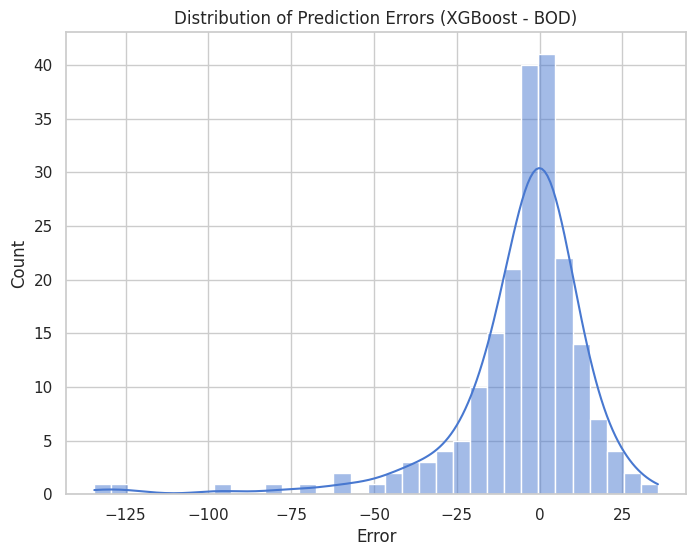

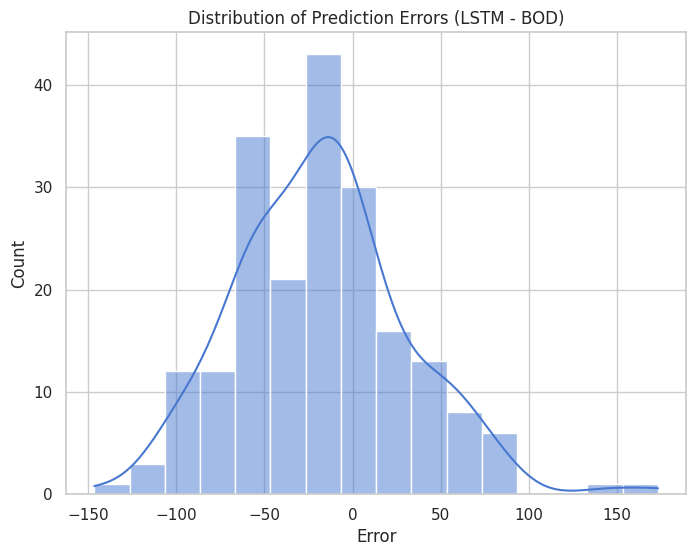

In [40]:
# Error histograms for BOD
for model_type, key in zip(['RandomForest', 'GradientBoosting', 'XGBoost', 'LSTM'], ['RF', 'GB', 'XGB', 'LSTM']):
    errors = y_true_common['BOD'] - predictions['BOD'][key]
    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True)
    plt.title(f'Distribution of Prediction Errors ({model_type} - BOD)')
    plt.xlabel('Error')
    plt.savefig(f'error_distribution_{model_type.lower().replace(" ", "_")}_bod.png')
    plt.show()

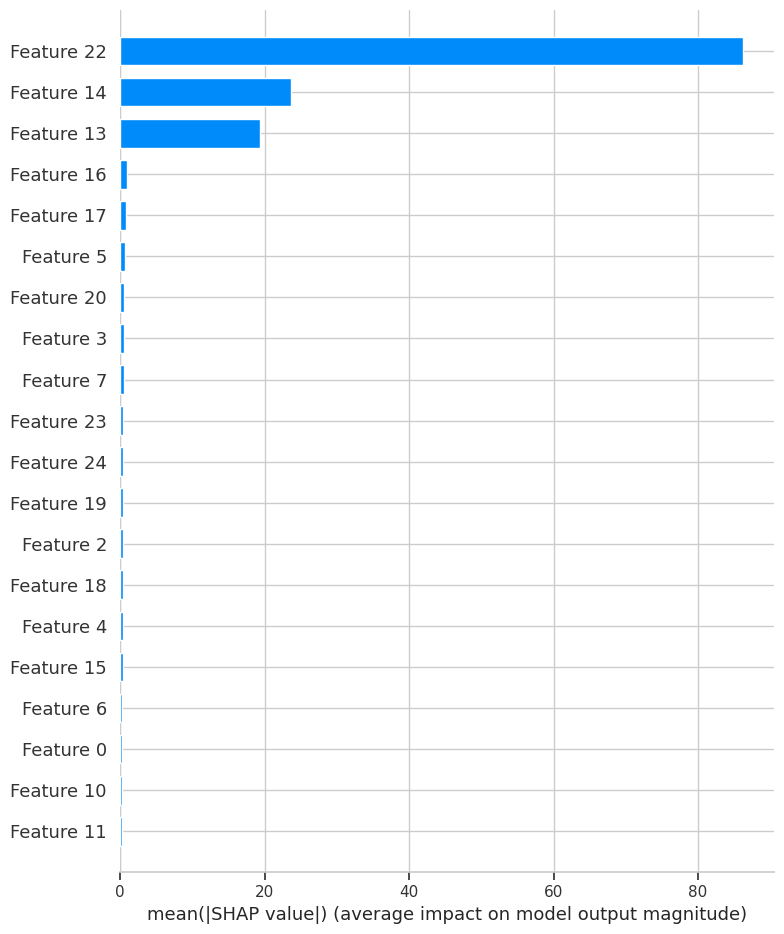

In [41]:
# SHAP Values for Random Forest on BOD

# Access the Random Forest model for BOD using the correct keys
explainer = shap.TreeExplainer(best_models['RandomForest']['BOD'])
shap_values = explainer.shap_values(X_test_common_scaled) # Assuming X_test_common_scaled is the scaled test data you want to use
shap.summary_plot(shap_values, X_test_common_scaled, plot_type="bar", show=False) # Assuming X_test_common_scaled is the test data
plt.savefig('shap_summary_BOD.png')
plt.show()

In [42]:
# Example for Random Forest BOD feature importance
importances = best_models['RandomForest']['BOD'].feature_importances_
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
print(feat_imp_df.head(10))


          Feature  Importance
22  BOD_roll_mean    0.558398
14       BOD_lag2    0.165817
13       BOD_lag1    0.127349
16       COD_lag1    0.013580
3              Am    0.010573
17       COD_lag2    0.008663
23  COD_roll_mean    0.008283
24   TN_roll_mean    0.007905
1      avg_inflow    0.007496
11             VM    0.007359


In [43]:
# Print features with their indexes to prove the mapping
print("Feature Index - Feature Name")
for idx, feature in enumerate(features):
    print(f"{idx}: {feature}")

# Specifically print what features are at index 14 and 22
print(f"Feature at index 14 is: {features[14]}")
print(f"Feature at index 22 is: {features[22]}")


Feature Index - Feature Name
0: avg_outflow
1: avg_inflow
2: total_grid
3: Am
4: T
5: TM
6: Tm
7: H
8: PP
9: VV
10: V
11: VM
12: VG
13: BOD_lag1
14: BOD_lag2
15: BOD_lag3
16: COD_lag1
17: COD_lag2
18: COD_lag3
19: TN_lag1
20: TN_lag2
21: TN_lag3
22: BOD_roll_mean
23: COD_roll_mean
24: TN_roll_mean
Feature at index 14 is: BOD_lag2
Feature at index 22 is: BOD_roll_mean


In [44]:
print("Feature index and names:")
for i, feat in enumerate(features):
    print(f"{i}: {feat}")


Feature index and names:
0: avg_outflow
1: avg_inflow
2: total_grid
3: Am
4: T
5: TM
6: Tm
7: H
8: PP
9: VV
10: V
11: VM
12: VG
13: BOD_lag1
14: BOD_lag2
15: BOD_lag3
16: COD_lag1
17: COD_lag2
18: COD_lag3
19: TN_lag1
20: TN_lag2
21: TN_lag3
22: BOD_roll_mean
23: COD_roll_mean
24: TN_roll_mean


In [45]:
# Interactive Plotly plot for BOD
import pandas as pd
import plotly.express as px

# Your plot code
plot_df = pd.DataFrame({
    'Date': df_test.index[:len(predictions['BOD']['actual'])],
    'Actual': predictions['BOD']['actual'],
    'Random Forest': predictions['BOD']['RF'],
    'Gradient Boosting': predictions['BOD']['GB'],
    'XGBoost': predictions['BOD']['XGB'],
    'LSTM': predictions['BOD']['LSTM'],
    'Ensemble': predictions['BOD']['Ensemble']
})
fig = px.line(plot_df.melt(id_vars='Date', var_name='Series', value_name='Value'),
              x='Date', y='Value', color='Series', title='Actual vs Predicted BOD')
fig.update_layout(hovermode='x unified')

# Display the plot inline
fig.show()

In [46]:
# Evaluate models
for target in targets:
    for model_type in ['RandomForest', 'GradientBoosting', 'XGBoost']:
        y_pred = best_models[model_type][target].predict(X_test_common_scaled)
        mae = mean_absolute_error(y_true_common[target], y_pred)
        rmse = np.sqrt(mean_squared_error(y_true_common[target], y_pred))
        r2 = r2_score(y_true_common[target], y_pred)
        print(f"{model_type} - {target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

    y_pred_scaled = best_models['LSTM'][target].predict(X_test_seq_scaled).flatten()
    y_pred = scalers_Y[target].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    mae = mean_absolute_error(y_true_common[target], y_pred)
    rmse = np.sqrt(mean_squared_error(y_true_common[target], y_pred))
    r2 = r2_score(y_true_common[target], y_pred)
    print(f"LSTM - {target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


RandomForest - BOD: MAE=18.2605, RMSE=27.4408, R2=0.7433
GradientBoosting - BOD: MAE=12.3761, RMSE=20.4834, R2=0.8569
XGBoost - BOD: MAE=12.8035, RMSE=22.2023, R2=0.8319
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM - BOD: MAE=40.8785, RMSE=51.7586, R2=0.0866
RandomForest - COD: MAE=32.3218, RMSE=43.7321, R2=0.8788
GradientBoosting - COD: MAE=19.2686, RMSE=27.1821, R2=0.9532
XGBoost - COD: MAE=20.4485, RMSE=29.1119, R2=0.9463
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM - COD: MAE=90.8709, RMSE=116.3888, R2=0.1417
RandomForest - TN: MAE=0.6606, RMSE=1.0297, R2=0.8452
GradientBoosting - TN: MAE=0.4440, RMSE=0.6369, R2=0.9408
XGBoost - TN: MAE=0.4431, RMSE=0.6392, R2=0.9403
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM - TN: MAE=1.7762, RMSE=2.5765, R2=0.0306
